# Modularized with utils.dm
This notebook now uses `utils/dm.py` for classification (Decision Tree, KNN) and association rule mining helpers, keeping outputs and artifacts unchanged.

# Section 2: Data Mining
## Task 3: Classification (Part A, 10 Marks) & Association Rule Mining (Part B, 10 Marks)
This notebook covers: (A) Decision Tree + KNN classification with metrics & visualization; (B) synthetic transactional data generation and Apriori association rule mining with analysis.

In [2]:
# 0. Setup: resolve project root, import utils.dm, configure options
import sys
from pathlib import Path
import numpy as np, random
ROOT = Path.cwd()
for parent in [ROOT] + list(ROOT.parents):
    if (parent / 'utils' / 'dm.py').exists():
        sys.path.insert(0, str(parent))
        break
from utils import dm
np.random.seed(42); random.seed(42)
ARTIFACT_DIR = Path('artifacts'); ARTIFACT_DIR.mkdir(exist_ok=True)
DATA_OPTION = 'iris'  # or 'synthetic'
print('Initialized: utils.dm available, DATA_OPTION=', DATA_OPTION)

Initialized: utils.dm available, DATA_OPTION= iris


In [3]:
# 1. Data Load & Split (via utils.dm)
df = dm.load_or_generate(DATA_OPTION)
X, y, feature_cols = dm.split_features(df)
X_scaled = dm.scale_features(X)
X_train, X_test, y_train, y_test = dm.train_test_split_custom(X_scaled, y, test_size=0.2, shuffle=True, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)

Train/Test shapes: (120, 4) (30, 4)


In [4]:
# Imports & setup via utils.dm (idempotent)
import sys
from pathlib import Path
if 'dm' not in globals():
    ROOT = Path.cwd()
    for parent in [ROOT] + list(ROOT.parents):
        if (parent / 'utils' / 'dm.py').exists():
            sys.path.insert(0, str(parent))
            break
    from utils import dm
import numpy as np, random
np.random.seed(42); random.seed(42)
ARTIFACT_DIR = Path('artifacts'); ARTIFACT_DIR.mkdir(exist_ok=True)
DATA_OPTION = 'iris'
print('Data option:', DATA_OPTION)

Data option: iris


Decision Tree -> Acc: 0.967 | Precision: 0.972 | Recall: 0.944 | F1: 0.955
Saved tree plot to artifacts/decision_tree_plot.png


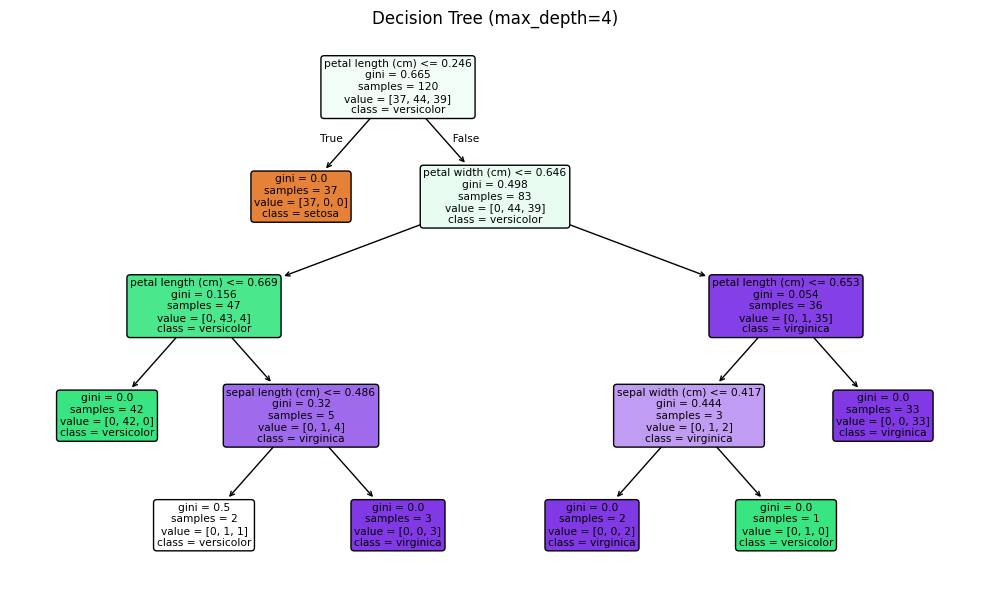

In [5]:
# 2. Decision Tree Classifier (Primary)
metrics_dt = dm.decision_tree_train_plot(
    X_train, y_train, X_test, y_test,
    feature_names=feature_cols,
    class_names=sorted(y.unique()),
    plot_path=Path('artifacts') / 'decision_tree_plot.png',
    max_depth=4,
)
print(f"Decision Tree -> Acc: {metrics_dt['accuracy']:.3f} | Precision: {metrics_dt['precision']:.3f} | Recall: {metrics_dt['recall']:.3f} | F1: {metrics_dt['f1']:.3f}")
print('Saved tree plot to artifacts/decision_tree_plot.png')

In [6]:
# 3. KNN Classifier (k=5) for Comparison
metrics_knn = dm.knn_train_eval(X_train, y_train, X_test, y_test, k=5)
print(f"KNN (k=5) -> Acc: {metrics_knn['accuracy']:.3f} | Precision: {metrics_knn['precision']:.3f} | Recall: {metrics_knn['recall']:.3f} | F1: {metrics_knn['f1']:.3f}")
import pandas as pd
comparison_df = pd.DataFrame([
    {'model':'DecisionTree', **metrics_dt},
    {'model':'KNN(k=5)', **metrics_knn}
]).set_index('model')
display(comparison_df)

KNN (k=5) -> Acc: 1.000 | Precision: 1.000 | Recall: 1.000 | F1: 1.000


,accuracy,precision,recall,f1
model,,,,
DecisionTree,0.966667,0.972222,0.944444,0.955204
KNN(k=5),1.000000,1.000000,1.000000,1.000000


### 4. Model Comparison & Rationale
The table above summarizes macro-averaged metrics. Generally, KNN often performs strongly on Iris due to well-separated species in petal space, while a constrained-depth tree provides interpretability. If their performance is similar, preference may lean toward the tree for explainability (clear decision paths). If KNN edges out in F1/accuracy, it suggests local neighborhood structure captures subtle class boundaries better than hierarchical splits. In production, pruning, cross-validation, or ensembling (e.g., Random Forest) could further improve robustness.

In [7]:
# 5. Part B: Synthetic Transactional Data Generation (via utils.dm)
transactions = dm.generate_synthetic_transactions(n_transactions=40, rng_seed=42)
print('Sample transactions (first 5):')
for t in transactions[:5]:
    print(t)

Sample transactions (first 5):
['bananas', 'beer', 'diapers', 'pasta', 'tomatoes']
['bananas', 'butter', 'cereal', 'chicken', 'coffee', 'onions', 'pasta', 'tea', 'yogurt']
['bread', 'cereal', 'chips']
['bananas', 'bread', 'coffee', 'milk', 'soda', 'tea']
['apples', 'beer', 'butter', 'chips', 'coffee', 'diapers', 'onions', 'rice', 'soda', 'tea']


In [8]:
# 6. Association Rule Mining via Apriori (utils.dm handles mlxtend or fallback)
rules = dm.apriori_rules(transactions, min_support=0.2, min_confidence=0.5)
import pandas as pd
if rules is None or (hasattr(rules, 'empty') and rules.empty):
    print('No rules found at given thresholds. Consider lowering support/confidence.')
else:
    # Ensure consistent dtype for serialization
    rules_sorted = rules.sort_values('lift', ascending=False).head(5).reset_index(drop=True)
    # Convert frozenset to strings for CSV
    def set_to_str(x):
        if isinstance(x, (set, frozenset)):
            return ','.join(sorted(list(x)))
        return x
    out_df = rules_sorted.copy()
    if 'antecedents' in out_df.columns:
        out_df['antecedents'] = out_df['antecedents'].apply(set_to_str)
    if 'consequents' in out_df.columns:
        out_df['consequents'] = out_df['consequents'].apply(set_to_str)
    out_df.to_csv(Path('artifacts') / 'top5_rules_partB.csv', index=False)
    display(out_df)
    print('Saved top 5 rules to artifacts/top5_rules_partB.csv')

,antecedents,consequents,support,confidence,lift
0,beer,diapers,0.225,0.750000,2.727273
1,diapers,beer,0.225,0.818182,2.727273
2,"bread,tea",milk,0.200,0.727273,1.711230
3,"onions,tea",coffee,0.200,1.000000,1.666667
4,diapers,soda,0.225,0.818182,1.636364


Saved top 5 rules to artifacts/top5_rules_partB.csv


### Task 3 Complete
Delivered classification metrics & visualization, comparative evaluation, synthetic transaction generation, Apriori mining, top rule export, and rule interpretation.